In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

## Restricted Boltzman Machine (RBM)

The classic reccurent neural network RBM starts with the energy function (Hamiltonian) according to the connection and activity in visible and hidden layer of neurons:

$E(s,\lambda)=-\Sigma a_iv_i - \Sigma b_jh_j - \Sigma v_i w_{ij} h_j$

where states $s=(u,h)$ correspond to visible and hidden binary states and weights of connectivity $\lambda=\{a_i, b_j, w_{ij}\}$. The assigned probability of activity configuration is given by Boltzman distribution:

$P_\lambda (s) = \frac{1}{Z(\beta,\lambda)}e^{-\beta E(s,\lambda)}$

where $Z$ is the partition function and $\beta=1/T$ for $k_B=1$. We can easily find the conditional probabilities:

$P_\lambda(v|h_j=1) = \sigma(\beta b_j + \beta \Sigma v_i w_{ij})$

$P_\lambda(h|v_i=1) = \sigma(\beta a_i + \beta \Sigma h_j w_{ij})$

where $\sigma(x)=\frac{1}{1+exp(-x)}$ is the sigmoid activation function. We then derive the weight update rule during learning:

$\frac{\delta \log P_\lambda(v)}{\delta w_{ij}} = <v_ih_j>_{data} - <v_ih_j>_{model}$

$\delta w_{ij} = \epsilon (<v_ih_j>_{data} - <v_ih_j>_{model})$

where $\epsilon$ is the learning rate and brackets are the expected value corresponding to data and model. Gibbs sampling is used for $<v_ih_j>_{model}$. An alternative is "reconstruction" hidden activity rather than simulation and sampling. This is related to the KL-divergence or Contrast Divergence (CD) objective functions.

### References:
- Hinton's practical guide: https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf
- Equivalence and phase space of Hopfield network: https://arxiv.org/pdf/1105.2790.pdf
- Thermodynamics and learning dynamics: https://arxiv.org/pdf/1803.01960.pdf
- Non-equilibrium thermodynamics of RBM: https://arxiv.org/pdf/1704.08724.pdf
- Deep-BM for MNIST data: https://physics.bu.edu/~pankajm/ML-Notebooks/HTML/NB_CXVI_RBM_mnist.html
- Simple verision from scratch: https://github.com/echen/restricted-boltzmann-machines

In [6]:
class RBM:
    def __init__(self, num_visible, num_hidden):
        self.num_hidden = num_hidden
        self.num_visible = num_visible
        self.debug_print = True

        # Initialize a weight matrix, of dimensions (num_visible x num_hidden), using
        # a uniform distribution between -sqrt(6. / (num_hidden + num_visible))
        # and sqrt(6. / (num_hidden + num_visible)). One could vary the 
        # standard deviation by multiplying the interval with appropriate value.
        # Here we initialize the weights with mean 0 and standard deviation 0.1. 
        # Reference: Understanding the difficulty of training deep feedforward 
        # neural networks by Xavier Glorot and Yoshua Bengio
        np_rng = np.random.RandomState(1234)
        self.weights = np.asarray(np_rng.uniform(
            low=-0.1 * np.sqrt(6. / (num_hidden + num_visible)),
            high=0.1 * np.sqrt(6. / (num_hidden + num_visible)),
            size=(num_visible, num_hidden)))

        # Insert weights for the bias units into the first row and first column.
        self.weights = np.insert(self.weights, 0, 0, axis = 0)
        self.weights = np.insert(self.weights, 0, 0, axis = 1)

    def train(self, data, max_epochs = 1000, learning_rate = 0.1):
        """
        Train the machine.

        Parameters
        ----------
        data: A matrix where each row is a training example consisting of the states of visible units.    
        """

        num_examples = data.shape[0]

        # Insert bias units of 1 into the first column.
        data = np.insert(data, 0, 1, axis = 1)

        for epoch in range(max_epochs):      
          # Clamp to the data and sample from the hidden units. 
          # (This is the "positive CD phase", aka the reality phase.)
            pos_hidden_activations = np.dot(data, self.weights)      
            pos_hidden_probs = self._logistic(pos_hidden_activations)
            pos_hidden_probs[:,0] = 1 # Fix the bias unit.
            pos_hidden_states = pos_hidden_probs > np.random.rand(num_examples, self.num_hidden + 1)
            # Note that we're using the activation *probabilities* of the hidden states, not the hidden states       
            # themselves, when computing associations. We could also use the states; see section 3 of Hinton's 
            # "A Practical Guide to Training Restricted Boltzmann Machines" for more.
            pos_associations = np.dot(data.T, pos_hidden_probs)

            # Reconstruct the visible units and sample again from the hidden units.
            # (This is the "negative CD phase", aka the daydreaming phase.)
            neg_visible_activations = np.dot(pos_hidden_states, self.weights.T)
            neg_visible_probs = self._logistic(neg_visible_activations)
            neg_visible_probs[:,0] = 1 # Fix the bias unit.
            neg_hidden_activations = np.dot(neg_visible_probs, self.weights)
            neg_hidden_probs = self._logistic(neg_hidden_activations)
            # Note, again, that we're using the activation *probabilities* when computing associations, not the states 
            # themselves.
            neg_associations = np.dot(neg_visible_probs.T, neg_hidden_probs)

            # Update weights.
            self.weights += learning_rate * ((pos_associations - neg_associations) / num_examples)

            error = np.sum((data - neg_visible_probs) ** 2)
            if self.debug_print:
                print("Epoch %s: error is %s" % (epoch, error))

    def run_visible(self, data):
        """
        Assuming the RBM has been trained (so that weights for the network have been learned),
        run the network on a set of visible units, to get a sample of the hidden units.

        Parameters
        ----------
        data: A matrix where each row consists of the states of the visible units.

        Returns
        -------
        hidden_states: A matrix where each row consists of the hidden units activated from the visible
        units in the data matrix passed in.
        """

        num_examples = data.shape[0]

        # Create a matrix, where each row is to be the hidden units (plus a bias unit)
        # sampled from a training example.
        hidden_states = np.ones((num_examples, self.num_hidden + 1))

        # Insert bias units of 1 into the first column of data.
        data = np.insert(data, 0, 1, axis = 1)

        # Calculate the activations of the hidden units.
        hidden_activations = np.dot(data, self.weights)
        # Calculate the probabilities of turning the hidden units on.
        hidden_probs = self._logistic(hidden_activations)
        # Turn the hidden units on with their specified probabilities.
        hidden_states[:,:] = hidden_probs > np.random.rand(num_examples, self.num_hidden + 1)
        # Always fix the bias unit to 1.
        # hidden_states[:,0] = 1

        # Ignore the bias units.
        hidden_states = hidden_states[:,1:]
        return hidden_states

    # TODO: Remove the code duplication between this method and `run_visible`?
    def run_hidden(self, data):
        """
        Assuming the RBM has been trained (so that weights for the network have been learned),
        run the network on a set of hidden units, to get a sample of the visible units.

        Parameters
        ----------
        data: A matrix where each row consists of the states of the hidden units.

        Returns
        -------
        visible_states: A matrix where each row consists of the visible units activated from the hidden
        units in the data matrix passed in.
        """

        num_examples = data.shape[0]

        # Create a matrix, where each row is to be the visible units (plus a bias unit)
        # sampled from a training example.
        visible_states = np.ones((num_examples, self.num_visible + 1))

        # Insert bias units of 1 into the first column of data.
        data = np.insert(data, 0, 1, axis = 1)

        # Calculate the activations of the visible units.
        visible_activations = np.dot(data, self.weights.T)
        # Calculate the probabilities of turning the visible units on.
        visible_probs = self._logistic(visible_activations)
        # Turn the visible units on with their specified probabilities.
        visible_states[:,:] = visible_probs > np.random.rand(num_examples, self.num_visible + 1)
        # Always fix the bias unit to 1.
        # visible_states[:,0] = 1

        # Ignore the bias units.
        visible_states = visible_states[:,1:]
        return visible_states

    def daydream(self, num_samples):
        """
        Randomly initialize the visible units once, and start running alternating Gibbs sampling steps
        (where each step consists of updating all the hidden units, and then updating all of the visible units),
        taking a sample of the visible units at each step.
        Note that we only initialize the network *once*, so these samples are correlated.

        Returns
        -------
        samples: A matrix, where each row is a sample of the visible units produced while the network was
        daydreaming.
        """

        # Create a matrix, where each row is to be a sample of of the visible units 
        # (with an extra bias unit), initialized to all ones.
        samples = np.ones((num_samples, self.num_visible + 1))

        # Take the first sample from a uniform distribution.
        samples[0,1:] = np.random.rand(self.num_visible)

        # Start the alternating Gibbs sampling.
        # Note that we keep the hidden units binary states, but leave the
        # visible units as real probabilities. See section 3 of Hinton's
        # "A Practical Guide to Training Restricted Boltzmann Machines"
        # for more on why.
        for i in range(1, num_samples):
            visible = samples[i-1,:]

            # Calculate the activations of the hidden units.
            hidden_activations = np.dot(visible, self.weights)      
            # Calculate the probabilities of turning the hidden units on.
            hidden_probs = self._logistic(hidden_activations)
            # Turn the hidden units on with their specified probabilities.
            hidden_states = hidden_probs > np.random.rand(self.num_hidden + 1)
            # Always fix the bias unit to 1.
            hidden_states[0] = 1

            # Recalculate the probabilities that the visible units are on.
            visible_activations = np.dot(hidden_states, self.weights.T)
            visible_probs = self._logistic(visible_activations)
            visible_states = visible_probs > np.random.rand(self.num_visible + 1)
            samples[i,:] = visible_states

        # Ignore the bias units (the first column), since they're always set to 1.
        return samples[:,1:]        
    
    def _logistic(self, x):
        return 1.0 / (1 + np.exp(-x))

if __name__ == '__main__':
    r = RBM(num_visible = 6, num_hidden = 3)
    training_data = np.array([[1,1,1,0,0,0],[1,0,1,0,0,0],[1,1,1,0,0,0],[0,0,1,1,1,0], [0,0,1,1,0,0],[0,0,1,1,1,0]])
    r.train(training_data, max_epochs = 5000)
    print(r.weights)
    user = np.array([[0,0,0,1,1,0]])
    print(r.run_visible(user))



Epoch 0: error is 8.779842536739283
Epoch 1: error is 8.687135892607703
Epoch 2: error is 8.411464339419542
Epoch 3: error is 8.098678123507069
Epoch 4: error is 8.029784646100909
Epoch 5: error is 7.65754305002302
Epoch 6: error is 7.643902287060436
Epoch 7: error is 7.19294570615089
Epoch 8: error is 7.535658984337847
Epoch 9: error is 7.359721658074498
Epoch 10: error is 7.1199900749723275
Epoch 11: error is 6.932068249912302
Epoch 12: error is 6.947943768633213
Epoch 13: error is 6.534871659464102
Epoch 14: error is 6.69990276079837
Epoch 15: error is 6.844017017194165
Epoch 16: error is 7.144611512010704
Epoch 17: error is 6.429280495314675
Epoch 18: error is 6.3482500816116705
Epoch 19: error is 6.336496449868299
Epoch 20: error is 6.249209344086177
Epoch 21: error is 6.3004773999680195
Epoch 22: error is 6.18049419263633
Epoch 23: error is 6.382487990532259
Epoch 24: error is 6.286358387861211
Epoch 25: error is 6.125451406215556
Epoch 26: error is 6.101954154421735
Epoch 27: er

Epoch 1614: error is 0.6893674878931099
Epoch 1615: error is 0.10977991896043018
Epoch 1616: error is 1.2301237273911212
Epoch 1617: error is 0.9133613496793201
Epoch 1618: error is 0.8059146160991821
Epoch 1619: error is 0.9104161148669896
Epoch 1620: error is 0.7058957290339051
Epoch 1621: error is 0.10422924468353188
Epoch 1622: error is 0.103713592844096
Epoch 1623: error is 0.801685861901199
Epoch 1624: error is 0.1031968633543113
Epoch 1625: error is 0.10269480198537162
Epoch 1626: error is 1.5255303632366857
Epoch 1627: error is 0.8035574423427098
Epoch 1628: error is 0.1024518228558252
Epoch 1629: error is 0.10195007751656575
Epoch 1630: error is 1.5145150355642936
Epoch 1631: error is 0.4171041049227632
Epoch 1632: error is 0.10066013879100354
Epoch 1633: error is 0.7104176184578995
Epoch 1634: error is 0.10092650141258715
Epoch 1635: error is 0.9094070491250997
Epoch 1636: error is 1.4135789004841752
Epoch 1637: error is 0.10000992833662899
Epoch 1638: error is 0.099531026197

Epoch 2935: error is 0.013007999252118358
Epoch 2936: error is 0.01299353574580232
Epoch 2937: error is 0.012979115182451513
Epoch 2938: error is 0.012964737253882206
Epoch 2939: error is 0.012950401655069239
Epoch 2940: error is 0.012936108084109563
Epoch 2941: error is 0.01292185624218611
Epoch 2942: error is 0.012907645833532206
Epoch 2943: error is 0.01289347656539645
Epoch 2944: error is 0.012879348148008072
Epoch 2945: error is 0.012865260294542595
Epoch 2946: error is 0.012851212721087819
Epoch 2947: error is 0.012837205146610652
Epoch 2948: error is 0.893929087058498
Epoch 2949: error is 0.012888291562757996
Epoch 2950: error is 0.01287355944582281
Epoch 2951: error is 0.012858875085166194
Epoch 2952: error is 0.012844238116494123
Epoch 2953: error is 0.012829648179330853
Epoch 2954: error is 1.828511694124774
Epoch 2955: error is 0.012800607976449859
Epoch 2956: error is 0.012786157008471124
Epoch 2957: error is 0.012771751667392191
Epoch 2958: error is 0.012757391611167538
Ep

Epoch 4225: error is 0.00501146376717318
Epoch 4226: error is 0.005008269892405833
Epoch 4227: error is 0.00500508107605107
Epoch 4228: error is 0.005001897297150112
Epoch 4229: error is 0.004998718534879247
Epoch 4230: error is 0.004995544768548806
Epoch 4231: error is 0.004992375977602109
Epoch 4232: error is 0.9587874282597489
Epoch 4233: error is 0.0049689800651279556
Epoch 4234: error is 0.9343052675097231
Epoch 4235: error is 0.004980012220529423
Epoch 4236: error is 0.00497686670854408
Epoch 4237: error is 1.8861866999655974
Epoch 4238: error is 0.004970590254131616
Epoch 4239: error is 0.004967459272408029
Epoch 4240: error is 0.004964333095017197
Epoch 4241: error is 0.004961211702622545
Epoch 4242: error is 0.004958095076010438
Epoch 4243: error is 0.0049549831960892755
Epoch 4244: error is 0.004951876043888699
Epoch 4245: error is 0.004948773600558613
Epoch 4246: error is 0.004945675847368325
Epoch 4247: error is 0.004942582765705595
Epoch 4248: error is 0.004939494337075852

In [11]:
# Given a new set of visible units, we can see what hidden units are activated.
#visible_data = np.array([[0,0,0,1,1,0]]) # A matrix with a single row that contains the states of the visible units. (We can also include more rows.)
#r.run_visible(visible_data) # See what hidden units are activated.

# Given a set of hidden units, we can see what visible units are activated.
hidden_data = np.array([[1,0,0]]) # A matrix with a single row that contains the states of the hidden units. (We can also include more rows.)
r.run_hidden(hidden_data) # See what visible units are activated.

# We can let the network run freely (aka, daydream).
r.daydream(100) # Daydream for 100 steps on a single initialization.

array([[0.78482545, 0.98325397, 0.67357904, 0.95145345, 0.8374424 ,
        0.588259  ],
       [0.        , 1.        , 1.        , 0.        , 1.        ,
        0.        ],
       [1.        , 1.        , 1.        , 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 1.        , 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 1.        , 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 1.        , 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 1.        , 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 1.        , 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 1.        , 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 1.        , 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 1.        , 0.        , 0.        ,
        0.        ],
       [1.        , 1

## From scratch!

In [2]:
def logistic(z):
    return 1.0 / (1 + np.exp(-z))

In [41]:
def Energy(v,h,W):
    return np.dot(np.dot(v,W),h.T)

In [44]:
### Training RBM ###
data_input = np.array([[1,1,1,0,0,0],[1,0,1,0,0,0],[1,1,1,0,0,0],[0,0,1,1,1,0],[0,0,1,1,0,0],[0,0,1,1,1,0]]) #exampleXfeature
data_input = data_input[:-2,:].copy()
max_ep = 1000
learn_rate = 0.1
num_exp = data_input.shape[0]  
num_vis = data_input.shape[1]  #corresponding to visible input
num_hid = 4  #number of hidden units
W = np.random.rand(num_vis,num_hid)#(num_exp, num_hid)
W = np.insert(W, 0, 0, axis = 0)
W = np.insert(W, 0, 0, axis = 1)
data = np.insert(data_input, 0, 1, axis = 1)  #bias term in the first column
Ens = []
Ers = []
E11s = []
E01s = []

for ep in range(max_ep):
    #Clamp (postive CD)
    P_h_act = np.dot(data, W)
    P_h = logistic(P_h_act)
    P_h[:,0] = 1  #fix bias
    P_h_state = P_h > np.random.rand(num_exp, num_hid + 1)
    P_aso = np.dot(data.T, P_h)

    #Reconstruct (negative CD)
    n_v_act = np.dot(P_h_state, W.T)
    n_v = logistic(n_v_act)
    n_v[:,0] = 1
    n_v_state = n_v > np.random.rand(num_exp, num_vis + 1) ##
    n_h_act = np.dot(n_v, W)
    n_h = logistic(n_h_act)
    n_h_state = n_h > np.random.rand(num_exp, num_hid + 1) ##
    n_aso = np.dot(n_v.T, n_h)
    
    E01 = np.sum(Energy(n_v_state, n_h_state, W)) ##
    #Update weights
    W += learn_rate* ((P_aso - n_aso) / num_exp)
    E11 = np.sum(Energy(n_v_state, n_h_state, W)) ##
    
    error = np.sum((data - n_v) ** 2)  #error term
    Ens.append(np.nansum(np.log(P_h_act+10**-8)))
    Ers.append(error)
    E11s.append(E11)
    E01s.append(E01)
    

/Users/Macintosh/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in log


In [56]:
E11s = np.array(E11s)
E01s = np.array(E01s)

Qs = E11s[1:]-E01s[1:]
Ws = E01s[1:]-E11s[:-1]

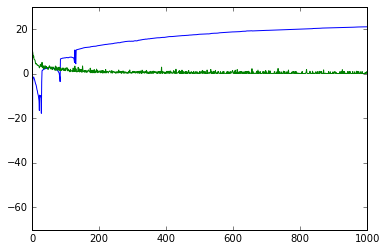

In [25]:
plt.plot(np.array(Ens))
plt.hold(True)
plt.plot(np.array(Ers))

In [13]:
### Re-activate
num_samp = 10
samples = np.ones((num_samples, self.num_visible + 1))

        # Take the first sample from a uniform distribution.
        samples[0,1:] = np.random.rand(self.num_visible)

        # Start the alternating Gibbs sampling.
        # Note that we keep the hidden units binary states, but leave the
        # visible units as real probabilities. See section 3 of Hinton's
        # "A Practical Guide to Training Restricted Boltzmann Machines"
        # for more on why.
        for i in range(1, num_samples):
            visible = samples[i-1,:]

            # Calculate the activations of the hidden units.
            hidden_activations = np.dot(visible, self.weights)      
            # Calculate the probabilities of turning the hidden units on.
            hidden_probs = self._logistic(hidden_activations)
            # Turn the hidden units on with their specified probabilities.
            hidden_states = hidden_probs > np.random.rand(self.num_hidden + 1)
            # Always fix the bias unit to 1.
            hidden_states[0] = 1

            # Recalculate the probabilities that the visible units are on.
            visible_activations = np.dot(hidden_states, self.weights.T)
            visible_probs = self._logistic(visible_activations)
            visible_states = visible_probs > np.random.rand(self.num_visible + 1)
            samples[i,:] = visible_states

        # Ignore the bias units (the first column), since they're always set to 1.
        return samples[:,1:]

IndentationError: unexpected indent (<ipython-input-13-c8122af4e466>, line 6)